## 1. Data Understanding and Exploration

In [27]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
from sklearn import linear_model, metrics
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import RFE
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error, r2_score

import os

# hide warnings
import warnings
warnings.filterwarnings('ignore')

In [28]:
housing = pd.read_csv('train.csv')
housing.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [29]:
housing.shape

(1460, 81)

In [30]:
housing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          91 non-null     object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseStyle     1460 non-null   object 
 17  OverallQual    1460 non-null   int64  
 18  OverallC

In [31]:
# Dropping the Id column
housing.drop(columns='Id', inplace = True)

## 2. Data Cleaning and Handling Missing Values

In [32]:
# compute null/non-null percentage for the entire dataframe
def compute_percentage(counts, flag):
    perc = 0
    if flag in counts.index:
        perc = round(100*(counts[flag]/housing.shape[0]), 2)
    return perc

# create a dictionary of columns that contain null vs. non-null percentage
cols_dict = {}
for col in list(housing.columns):
    counts = housing[col].isnull().value_counts()      #count null values
    false_perc = compute_percentage(counts, False)  #percentage of non-null values
    true_perc = compute_percentage(counts, True)    #percentage of null values
    
    if false_perc < 100:   #only adding columns to the dict which have null values
        cols_dict[col] = {'non_null_perc' : false_perc, 'null_perc' : true_perc}
        
# create a data frame of columns that have missing values along with null vs. non-null percentage
cols_housing = pd.DataFrame(cols_dict).T
cols_housing.head()

,non_null_perc,null_perc
LotFrontage,82.26,17.74
Alley,6.23,93.77
MasVnrType,99.45,0.55
MasVnrArea,99.45,0.55
BsmtQual,97.47,2.53


In [33]:
# Features having high null percentage
high_null_cols = cols_housing[cols_housing['null_perc'] > 90]
high_null_cols

,non_null_perc,null_perc
Alley,6.23,93.77
PoolQC,0.48,99.52
MiscFeature,3.70,96.30


In [34]:
# Dropping the columns which have least significant information
housing.drop(columns=list(high_null_cols.index), inplace=True)
housing.shape

(1460, 77)

#### Mapping Categories according to Data Dictionary

In [35]:
# According to Data Dictionary, changing values to 'NA'(No Access) which are misinterpreted as null.
templist1 = ['BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'FireplaceQu', 
            'GarageType', 'GarageFinish', 'GarageQual', 'GarageCond', 'Fence']
housing[templist1] = housing[templist1].fillna('NA')
housing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 77 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   MSSubClass     1460 non-null   int64  
 1   MSZoning       1460 non-null   object 
 2   LotFrontage    1201 non-null   float64
 3   LotArea        1460 non-null   int64  
 4   Street         1460 non-null   object 
 5   LotShape       1460 non-null   object 
 6   LandContour    1460 non-null   object 
 7   Utilities      1460 non-null   object 
 8   LotConfig      1460 non-null   object 
 9   LandSlope      1460 non-null   object 
 10  Neighborhood   1460 non-null   object 
 11  Condition1     1460 non-null   object 
 12  Condition2     1460 non-null   object 
 13  BldgType       1460 non-null   object 
 14  HouseStyle     1460 non-null   object 
 15  OverallQual    1460 non-null   int64  
 16  OverallCond    1460 non-null   int64  
 17  YearBuilt      1460 non-null   int64  
 18  YearRemo

In [36]:
# Mapping the MSSubClass column
housing['MSSubClass'] = housing['MSSubClass'].map({20: '1-STORY 1946 & NEWER ALL STYLES',
                                                  30: '1-STORY 1945 & OLDER',
                                                  40: '1-STORY W/FINISHED ATTIC ALL AGES',
                                                  45: '1-1/2 STORY - UNFINISHED ALL AGES',
                                                  50: '1-1/2 STORY FINISHED ALL AGES',
                                                  60: '2-STORY 1946 & NEWER',
                                                  70: '2-STORY 1945 & OLDER',
                                                  75: '2-1/2 STORY ALL AGES',
                                                  80: 'SPLIT OR MULTI-LEVEL',
                                                  85: 'SPLIT FOYER',
                                                  90: 'DUPLEX - ALL STYLES AND AGES',
                                                  120: '1-STORY PUD (Planned Unit Development) - 1946 & NEWER',
                                                  150: '1-1/2 STORY PUD - ALL AGES',
                                                  160: '2-STORY PUD - 1946 & NEWER',
                                                  180: 'PUD - MULTILEVEL - INCL SPLIT LEV/FOYER',
                                                  190: '2 FAMILY CONVERSION - ALL STYLES AND AGES'})
housing['MSSubClass'].value_counts()

1-STORY 1946 & NEWER ALL STYLES                          536
2-STORY 1946 & NEWER                                     299
1-1/2 STORY FINISHED ALL AGES                            144
1-STORY PUD (Planned Unit Development) - 1946 & NEWER     87
1-STORY 1945 & OLDER                                      69
2-STORY PUD - 1946 & NEWER                                63
2-STORY 1945 & OLDER                                      60
SPLIT OR MULTI-LEVEL                                      58
DUPLEX - ALL STYLES AND AGES                              52
2 FAMILY CONVERSION - ALL STYLES AND AGES                 30
SPLIT FOYER                                               20
2-1/2 STORY ALL AGES                                      16
1-1/2 STORY - UNFINISHED ALL AGES                         12
PUD - MULTILEVEL - INCL SPLIT LEV/FOYER                   10
1-STORY W/FINISHED ATTIC ALL AGES                          4
Name: MSSubClass, dtype: int64

In [37]:
# Mapping 'OverallQual' and 'OverallCond' columns

templist2 = ['OverallQual', 'OverallCond']

def quality(x):
    return x.map({10: 'Very Excellent', 9: 'Excellent', 8: 'Very Good', 7: 'Good', 6: 'Above Average',
                 5: 'Average', 4: 'Below Average', 3: 'Fair', 2: 'Poor', 1: 'Very Poor'})

housing[templist2] = housing[templist2].apply(quality)
housing['OverallCond'].value_counts()

Average          821
Above Average    252
Good             205
Very Good         72
Below Average     57
Fair              25
Excellent         22
Poor               5
Very Poor          1
Name: OverallCond, dtype: int64

In [38]:
# Correcting the data format of 'GarageYrBlt' column.
housing['GarageYrBlt'] = housing[housing['GarageYrBlt'].notnull()]['GarageYrBlt'].astype('str').apply(lambda x: x.replace('.0', ''))

# Changing the values in 'GarageYrBlt' to 'NA' which are misinterpreted as null.
housing['GarageYrBlt'] = housing['GarageYrBlt'].fillna('NA')
housing['GarageYrBlt'].value_counts()

NA      81
2005    65
2006    59
2004    53
2003    50
        ..
1908     1
1900     1
1906     1
1927     1
1933     1
Name: GarageYrBlt, Length: 98, dtype: int64

#### Inpecting the columns again for missing values

In [39]:
housing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 77 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   MSSubClass     1460 non-null   object 
 1   MSZoning       1460 non-null   object 
 2   LotFrontage    1201 non-null   float64
 3   LotArea        1460 non-null   int64  
 4   Street         1460 non-null   object 
 5   LotShape       1460 non-null   object 
 6   LandContour    1460 non-null   object 
 7   Utilities      1460 non-null   object 
 8   LotConfig      1460 non-null   object 
 9   LandSlope      1460 non-null   object 
 10  Neighborhood   1460 non-null   object 
 11  Condition1     1460 non-null   object 
 12  Condition2     1460 non-null   object 
 13  BldgType       1460 non-null   object 
 14  HouseStyle     1460 non-null   object 
 15  OverallQual    1460 non-null   object 
 16  OverallCond    1460 non-null   object 
 17  YearBuilt      1460 non-null   int64  
 18  YearRemo

In [40]:
# Inspecting the 'LotFrontage' column
housing['LotFrontage'].describe()

count    1201.000000
mean       70.049958
std        24.284752
min        21.000000
25%        59.000000
50%        69.000000
75%        80.000000
max       313.000000
Name: LotFrontage, dtype: float64

In [41]:
# Imputing missing values of 'LotFrontage' column by its median
housing['LotFrontage'] = housing['LotFrontage'].fillna(housing['LotFrontage'].median())

In [42]:
# Inspecting the 'MasVnrType' column
housing['MasVnrType'].value_counts()

None       864
BrkFace    445
Stone      128
BrkCmn      15
Name: MasVnrType, dtype: int64

In [43]:
# Imputing missing values of 'MasVnrType' column by its mode
housing['MasVnrType'] = housing['MasVnrType'].fillna(housing['MasVnrType'].mode()[0])

In [44]:
# Inspecting the 'MasVnrArea' column
housing['MasVnrArea'].describe()

count    1452.000000
mean      103.685262
std       181.066207
min         0.000000
25%         0.000000
50%         0.000000
75%       166.000000
max      1600.000000
Name: MasVnrArea, dtype: float64

In [45]:
# Imputing missing values of 'MasVnrArea' column by its median
housing['MasVnrArea'] = housing['MasVnrArea'].fillna(housing['MasVnrArea'].median())

In [46]:
# Inspecting the 'Electrical' column
housing['Electrical'].value_counts()

SBrkr    1334
FuseA      94
FuseF      27
FuseP       3
Mix         1
Name: Electrical, dtype: int64

In [47]:
# Imputing missing values of 'Electrical' column by its mode
housing['Electrical'] = housing['Electrical'].fillna(housing['Electrical'].mode()[0])

In [48]:
housing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 77 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   MSSubClass     1460 non-null   object 
 1   MSZoning       1460 non-null   object 
 2   LotFrontage    1460 non-null   float64
 3   LotArea        1460 non-null   int64  
 4   Street         1460 non-null   object 
 5   LotShape       1460 non-null   object 
 6   LandContour    1460 non-null   object 
 7   Utilities      1460 non-null   object 
 8   LotConfig      1460 non-null   object 
 9   LandSlope      1460 non-null   object 
 10  Neighborhood   1460 non-null   object 
 11  Condition1     1460 non-null   object 
 12  Condition2     1460 non-null   object 
 13  BldgType       1460 non-null   object 
 14  HouseStyle     1460 non-null   object 
 15  OverallQual    1460 non-null   object 
 16  OverallCond    1460 non-null   object 
 17  YearBuilt      1460 non-null   int64  
 18  YearRemo

In [49]:
# Coverting the given columns to categorical.
housing[['BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 
        'TotRmsAbvGrd', 'Fireplaces', 'GarageCars', 'MoSold']] = housing[['BsmtFullBath', 'BsmtHalfBath', 
                                                                         'FullBath', 'HalfBath', 'BedroomAbvGr',
                                                                         'KitchenAbvGr', 'TotRmsAbvGrd',
                                                                         'Fireplaces', 'GarageCars',
                                                                         'MoSold']].astype('object')

In [50]:
# All numeric variables in the dataset
housing_numeric = housing.select_dtypes(include = ['float64', 'int64'])
housing_numeric.head()

,LotFrontage,LotArea,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,1stFlrSF,...,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,YrSold,SalePrice
0,65.0,8450,2003,2003,196.0,706,0,150,856,856,...,548,0,61,0,0,0,0,0,2008,208500
1,80.0,9600,1976,1976,0.0,978,0,284,1262,1262,...,460,298,0,0,0,0,0,0,2007,181500
2,68.0,11250,2001,2002,162.0,486,0,434,920,920,...,608,0,42,0,0,0,0,0,2008,223500
3,60.0,9550,1915,1970,0.0,216,0,540,756,961,...,642,0,35,272,0,0,0,0,2006,140000
4,84.0,14260,2000,2000,350.0,655,0,490,1145,1145,...,836,192,84,0,0,0,0,0,2008,250000


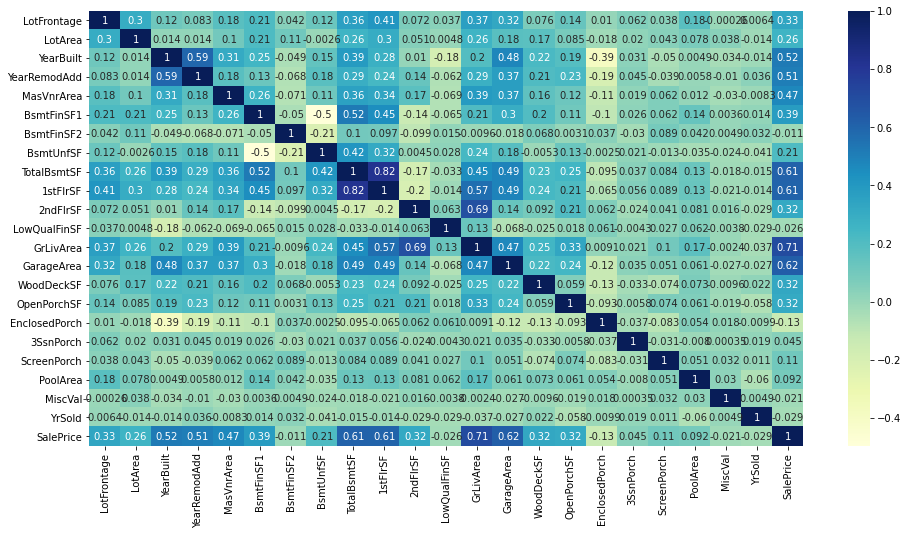

In [51]:
# Plotting the correlations on heatmap
plt.figure(figsize=(16,8))
sns.heatmap(housing_numeric.corr(), cmap="YlGnBu", annot=True)
plt.show()

## 3. Data Preparation

In [52]:
# Creating dummy variables for categorical features
housing_categorical = housing.select_dtypes(include = 'object')
housing_categorical.head()

,MSSubClass,MSZoning,Street,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,...,GarageYrBlt,GarageFinish,GarageCars,GarageQual,GarageCond,PavedDrive,Fence,MoSold,SaleType,SaleCondition
0,2-STORY 1946 & NEWER,RL,Pave,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,...,2003,RFn,2,TA,TA,Y,NA,2,WD,Normal
1,1-STORY 1946 & NEWER ALL STYLES,RL,Pave,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,...,1976,RFn,2,TA,TA,Y,NA,5,WD,Normal
2,2-STORY 1946 & NEWER,RL,Pave,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,...,2001,RFn,2,TA,TA,Y,NA,9,WD,Normal
3,2-STORY 1945 & OLDER,RL,Pave,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,...,1998,Unf,3,TA,TA,Y,NA,2,WD,Abnorml
4,2-STORY 1946 & NEWER,RL,Pave,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,...,2000,RFn,3,TA,TA,Y,NA,12,WD,Normal


In [53]:
# Convert into dummies - one hot encoding
housing_dummies = pd.get_dummies(housing_categorical, drop_first=True)
housing_dummies.shape

(1460, 391)

In [54]:
# Dropping categorical columns
housing = housing.drop(list(housing_categorical.columns), axis = 1)

In [55]:
# Concatting dummy variables with X
housing = pd.concat([housing, housing_dummies], axis = 1)

#### Splitting the Data into Training and Test Sets

In [56]:
# Split into train and test
from sklearn.model_selection import train_test_split
df_train, df_test = train_test_split(housing, train_size=0.7,test_size = 0.3, random_state=100)

#### Rescaling the Features

In [57]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()

# Scaling the training set
df_train[list(df_train.columns)] = scaler.fit_transform(df_train[list(df_train.columns)])
df_train.head()

,LotFrontage,LotArea,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,1stFlrSF,...,SaleType_ConLI,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
210,0.157534,0.019306,0.384058,0.000000,0.00,0.082920,0.0,0.169521,0.141408,0.113889,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
318,0.236301,0.039403,0.876812,0.716667,0.16,0.174876,0.0,0.154110,0.220458,0.231481,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
239,0.106164,0.033981,0.528986,0.000000,0.00,0.016655,0.0,0.274401,0.120295,0.098611,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
986,0.130137,0.017931,0.275362,0.883333,0.00,0.000000,0.0,0.207620,0.079378,0.145602,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
1416,0.133562,0.046139,0.094203,0.000000,0.00,0.000000,0.0,0.332620,0.127169,0.202315,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0


In [58]:
# Scaling the test set also
df_test[list(df_test.columns)] = scaler.transform(df_test[list(df_test.columns)])
df_test.head()

,LotFrontage,LotArea,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,1stFlrSF,...,SaleType_ConLI,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
1436,0.133562,0.035192,0.717391,0.350000,0.00000,0.109142,0.0,0.106164,0.141408,0.113889,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
57,0.232877,0.047566,0.956522,0.900000,0.00000,0.000000,0.0,0.368151,0.140753,0.112963,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
780,0.143836,0.029930,0.891304,0.766667,0.02375,0.000000,0.0,0.529538,0.202455,0.203935,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
382,0.198630,0.036338,0.971014,0.933333,0.00000,0.000000,0.0,0.401969,0.153682,0.131250,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
1170,0.188356,0.039309,0.760870,0.450000,0.00000,0.092488,0.0,0.245719,0.179378,0.172685,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0


In [59]:
# Dividing into X_train, y_train, X_test, y_test
y_train = df_train.pop('SalePrice')
X_train = df_train

y_test = df_test.pop('SalePrice')
X_test = df_test

## 4. Model Building

## Linear Regression

In [60]:
lm = LinearRegression()
lm.fit(X_train, y_train)

# Selecting 20 Features using RFE
rfe = RFE(lm, 20)
rfe = rfe.fit(X_train, y_train)

In [61]:
col = X_train.columns[rfe.support_]
col

Index(['BsmtFinSF1', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF',
       'GrLivArea', 'Condition2_PosN', 'OverallQual_Very Excellent',
       'RoofMatl_CompShg', 'RoofMatl_Membran', 'RoofMatl_Metal',
       'RoofMatl_Roll', 'RoofMatl_Tar&Grv', 'RoofMatl_WdShake',
       'RoofMatl_WdShngl', 'Exterior1st_CBlock', 'BsmtFinType1_NA',
       'KitchenAbvGr_1', 'Functional_Sev', 'GarageCars_3'],
      dtype='object')

In [62]:
X_train_rfe = X_train[col]

### Manually eliminating features using statistics and VIF

In [63]:
# Adding a constant variable
import statsmodels.api as sm
X_train_rfe = sm.add_constant(X_train_rfe)

In [64]:
# Running the Linear Model
lm = sm.OLS(y_train, X_train_rfe).fit()

# Summary of our linear model
print(lm.summary())

                            OLS Regression Results                            
Dep. Variable:              SalePrice   R-squared:                       0.833
Model:                            OLS   Adj. R-squared:                  0.830
Method:                 Least Squares   F-statistic:                     263.5
Date:                Mon, 25 Jan 2021   Prob (F-statistic):               0.00
Time:                        23:26:23   Log-Likelihood:                 1721.7
No. Observations:                1021   AIC:                            -3403.
Df Residuals:                    1001   BIC:                            -3305.
Df Model:                          19                                         
Covariance Type:            nonrobust                                         
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------
const               

In [65]:
# Calculating the VIFs for the model
X_train_vif = X_train_rfe.drop(columns='const')     # Dropping the constant column

from statsmodels.stats.outliers_influence import variance_inflation_factor

vif = pd.DataFrame()
X = X_train_vif
vif['Features'] = X.columns
vif['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = 'VIF', ascending = False)
vif

,Features,VIF
5,GrLivArea,520468.51
2,1stFlrSF,285567.62
3,2ndFlrSF,110097.79
4,LowQualFinSF,848.23
8,RoofMatl_CompShg,24.28
12,RoofMatl_Tar&Grv,9.32
1,TotalBsmtSF,6.98
13,RoofMatl_WdShake,6.54
14,RoofMatl_WdShngl,6.16
11,RoofMatl_Roll,2.39


In [66]:
# Dropping 'GrLivArea' as it has high VIF
X_train_new = X_train_vif.drop(columns = 'GrLivArea')

In [67]:
# Rebuilding the model without column 'GrLivArea'

X_train_lm = sm.add_constant(X_train_new)

lm = sm.OLS(y_train, X_train_lm).fit()
print(lm.summary())

                            OLS Regression Results                            
Dep. Variable:              SalePrice   R-squared:                       0.833
Model:                            OLS   Adj. R-squared:                  0.830
Method:                 Least Squares   F-statistic:                     263.5
Date:                Mon, 25 Jan 2021   Prob (F-statistic):               0.00
Time:                        23:26:24   Log-Likelihood:                 1721.7
No. Observations:                1021   AIC:                            -3403.
Df Residuals:                    1001   BIC:                            -3305.
Df Model:                          19                                         
Covariance Type:            nonrobust                                         
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------
const               

In [68]:
# Calculating the VIFs again for the new model
X_train_vif = X_train_lm.drop(columns='const')     # Dropping the constant column

from statsmodels.stats.outliers_influence import variance_inflation_factor

vif = pd.DataFrame()
X = X_train_vif
vif['Features'] = X.columns
vif['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = 'VIF', ascending = False)
vif

,Features,VIF
1,TotalBsmtSF,40.03
7,RoofMatl_CompShg,34.51
2,1stFlrSF,24.28
16,KitchenAbvGr_1,22.41
0,BsmtFinSF1,2.84
15,BsmtFinType1_NA,2.01
3,2ndFlrSF,1.93
18,GarageCars_3,1.49
11,RoofMatl_Tar&Grv,1.46
6,OverallQual_Very Excellent,1.35


In [69]:
# Dropping 'TotalBsmtSF' as it has high VIF
X_train_new = X_train_vif.drop(columns = 'TotalBsmtSF')

In [70]:
# Rebuilding the model without column 'TotalBsmtSF'

X_train_lm = sm.add_constant(X_train_new)

lm = sm.OLS(y_train, X_train_lm).fit()
print(lm.summary())

                            OLS Regression Results                            
Dep. Variable:              SalePrice   R-squared:                       0.814
Model:                            OLS   Adj. R-squared:                  0.810
Method:                 Least Squares   F-statistic:                     243.2
Date:                Mon, 25 Jan 2021   Prob (F-statistic):               0.00
Time:                        23:26:24   Log-Likelihood:                 1665.0
No. Observations:                1021   AIC:                            -3292.
Df Residuals:                    1002   BIC:                            -3198.
Df Model:                          18                                         
Covariance Type:            nonrobust                                         
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------
const               

In [71]:
# Calculating the VIFs again for the new model
X_train_vif = X_train_lm.drop(columns='const')     # Dropping the constant column

from statsmodels.stats.outliers_influence import variance_inflation_factor

vif = pd.DataFrame()
X = X_train_vif
vif['Features'] = X.columns
vif['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = 'VIF', ascending = False)
vif

,Features,VIF
6,RoofMatl_CompShg,31.39
15,KitchenAbvGr_1,22.35
1,1stFlrSF,8.09
0,BsmtFinSF1,2.62
2,2ndFlrSF,1.91
10,RoofMatl_Tar&Grv,1.44
17,GarageCars_3,1.44
5,OverallQual_Very Excellent,1.32
14,BsmtFinType1_NA,1.22
11,RoofMatl_WdShake,1.21


In [72]:
# Dropping 'RoofMatl_CompShg' as it has high VIF
X_train_new = X_train_vif.drop(columns = 'RoofMatl_CompShg')

In [73]:
# Rebuilding the model without column 'RoofMatl_CompShg'

X_train_lm = sm.add_constant(X_train_new)

lm = sm.OLS(y_train, X_train_lm).fit()
print(lm.summary())

                            OLS Regression Results                            
Dep. Variable:              SalePrice   R-squared:                       0.745
Model:                            OLS   Adj. R-squared:                  0.740
Method:                 Least Squares   F-statistic:                     172.1
Date:                Mon, 25 Jan 2021   Prob (F-statistic):          6.17e-283
Time:                        23:26:24   Log-Likelihood:                 1504.0
No. Observations:                1021   AIC:                            -2972.
Df Residuals:                    1003   BIC:                            -2883.
Df Model:                          17                                         
Covariance Type:            nonrobust                                         
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------
const               

In [74]:
# Calculating the VIFs again for the new model
X_train_vif = X_train_lm.drop(columns='const')     # Dropping the constant column

from statsmodels.stats.outliers_influence import variance_inflation_factor

vif = pd.DataFrame()
X = X_train_vif
vif['Features'] = X.columns
vif['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = 'VIF', ascending = False)
vif

,Features,VIF
1,1stFlrSF,6.18
14,KitchenAbvGr_1,5.25
0,BsmtFinSF1,2.61
2,2ndFlrSF,1.68
16,GarageCars_3,1.40
5,OverallQual_Very Excellent,1.27
9,RoofMatl_Tar&Grv,1.22
15,Functional_Sev,1.21
4,Condition2_PosN,1.09
13,BsmtFinType1_NA,1.08


In [75]:
# Dropping 'RoofMatl_Roll' as it is not significant
X_train_new = X_train_vif.drop(columns = 'RoofMatl_Roll')

In [76]:
# Rebuilding the model without column 'RoofMatl_Roll'

X_train_lm = sm.add_constant(X_train_new)

lm = sm.OLS(y_train, X_train_lm).fit()
print(lm.summary())

                            OLS Regression Results                            
Dep. Variable:              SalePrice   R-squared:                       0.745
Model:                            OLS   Adj. R-squared:                  0.741
Method:                 Least Squares   F-statistic:                     183.1
Date:                Mon, 25 Jan 2021   Prob (F-statistic):          4.58e-284
Time:                        23:26:24   Log-Likelihood:                 1503.9
No. Observations:                1021   AIC:                            -2974.
Df Residuals:                    1004   BIC:                            -2890.
Df Model:                          16                                         
Covariance Type:            nonrobust                                         
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------
const               

In [77]:
# Calculating the VIFs again for the new model
X_train_vif = X_train_lm.drop(columns='const')     # Dropping the constant column

from statsmodels.stats.outliers_influence import variance_inflation_factor

vif = pd.DataFrame()
X = X_train_vif
vif['Features'] = X.columns
vif['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = 'VIF', ascending = False)
vif

,Features,VIF
1,1stFlrSF,6.16
13,KitchenAbvGr_1,5.23
0,BsmtFinSF1,2.61
2,2ndFlrSF,1.67
15,GarageCars_3,1.40
5,OverallQual_Very Excellent,1.27
8,RoofMatl_Tar&Grv,1.22
14,Functional_Sev,1.21
4,Condition2_PosN,1.09
12,BsmtFinType1_NA,1.08


In [78]:
# Dropping 'RoofMatl_Tar&Grv' as it is not significant
X_train_new = X_train_vif.drop(columns = 'RoofMatl_Tar&Grv')

In [79]:
# Rebuilding the model without column 'RoofMatl_Tar&Grv'

X_train_lm = sm.add_constant(X_train_new)

lm = sm.OLS(y_train, X_train_lm).fit()
print(lm.summary())

                            OLS Regression Results                            
Dep. Variable:              SalePrice   R-squared:                       0.745
Model:                            OLS   Adj. R-squared:                  0.741
Method:                 Least Squares   F-statistic:                     195.4
Date:                Mon, 25 Jan 2021   Prob (F-statistic):          3.36e-285
Time:                        23:26:24   Log-Likelihood:                 1503.9
No. Observations:                1021   AIC:                            -2976.
Df Residuals:                    1005   BIC:                            -2897.
Df Model:                          15                                         
Covariance Type:            nonrobust                                         
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------
const               

In [80]:
# Calculating the VIFs again for the new model
X_train_vif = X_train_lm.drop(columns='const')     # Dropping the constant column

from statsmodels.stats.outliers_influence import variance_inflation_factor

vif = pd.DataFrame()
X = X_train_vif
vif['Features'] = X.columns
vif['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = 'VIF', ascending = False)
vif

,Features,VIF
1,1stFlrSF,6.16
12,KitchenAbvGr_1,5.22
0,BsmtFinSF1,2.61
2,2ndFlrSF,1.67
14,GarageCars_3,1.40
5,OverallQual_Very Excellent,1.27
4,Condition2_PosN,1.09
11,BsmtFinType1_NA,1.07
3,LowQualFinSF,1.03
9,RoofMatl_WdShngl,1.03


In [81]:
# Dropping 'RoofMatl_WdShake' as it is not significant
X_train_new = X_train_vif.drop(columns = 'RoofMatl_WdShake')

In [82]:
# Rebuilding the model without column 'RoofMatl_WdShake'

X_train_lm = sm.add_constant(X_train_new)

lm = sm.OLS(y_train, X_train_lm).fit()
print(lm.summary())

                            OLS Regression Results                            
Dep. Variable:              SalePrice   R-squared:                       0.745
Model:                            OLS   Adj. R-squared:                  0.741
Method:                 Least Squares   F-statistic:                     209.4
Date:                Mon, 25 Jan 2021   Prob (F-statistic):          2.95e-286
Time:                        23:26:25   Log-Likelihood:                 1503.6
No. Observations:                1021   AIC:                            -2977.
Df Residuals:                    1006   BIC:                            -2903.
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------
const               

In [83]:
# Calculating the VIFs again for the new model
X_train_vif = X_train_lm.drop(columns='const')     # Dropping the constant column

from statsmodels.stats.outliers_influence import variance_inflation_factor

vif = pd.DataFrame()
X = X_train_vif
vif['Features'] = X.columns
vif['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = 'VIF', ascending = False)
vif

,Features,VIF
1,1stFlrSF,6.07
11,KitchenAbvGr_1,5.20
0,BsmtFinSF1,2.61
2,2ndFlrSF,1.67
13,GarageCars_3,1.39
5,OverallQual_Very Excellent,1.27
4,Condition2_PosN,1.09
10,BsmtFinType1_NA,1.07
3,LowQualFinSF,1.03
8,RoofMatl_WdShngl,1.03


In [84]:
# Dropping 'RoofMatl_Metal' as it is not significant
X_train_new = X_train_vif.drop(columns = 'RoofMatl_Metal')

In [85]:
# Rebuilding the model without column 'RoofMatl_Metal'

X_train_lm = sm.add_constant(X_train_new)

lm = sm.OLS(y_train, X_train_lm).fit()
print(lm.summary())

                            OLS Regression Results                            
Dep. Variable:              SalePrice   R-squared:                       0.744
Model:                            OLS   Adj. R-squared:                  0.741
Method:                 Least Squares   F-statistic:                     225.5
Date:                Mon, 25 Jan 2021   Prob (F-statistic):          3.03e-287
Time:                        23:26:25   Log-Likelihood:                 1503.2
No. Observations:                1021   AIC:                            -2978.
Df Residuals:                    1007   BIC:                            -2909.
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------
const               

In [86]:
# Calculating the VIFs again for the new model
X_train_vif = X_train_lm.drop(columns='const')     # Dropping the constant column

from statsmodels.stats.outliers_influence import variance_inflation_factor

vif = pd.DataFrame()
X = X_train_vif
vif['Features'] = X.columns
vif['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = 'VIF', ascending = False)
vif

,Features,VIF
1,1stFlrSF,6.07
10,KitchenAbvGr_1,5.19
0,BsmtFinSF1,2.61
2,2ndFlrSF,1.66
12,GarageCars_3,1.39
5,OverallQual_Very Excellent,1.27
4,Condition2_PosN,1.09
9,BsmtFinType1_NA,1.07
3,LowQualFinSF,1.03
7,RoofMatl_WdShngl,1.03


In [87]:
# Dropping 'RoofMatl_Metal' as it is not significant
X_train_new = X_train_vif.drop(columns = 'Exterior1st_CBlock')

In [88]:
# Rebuilding the model without column 'Exterior1st_CBlock'

X_train_lm = sm.add_constant(X_train_new)

lm = sm.OLS(y_train, X_train_lm).fit()
print(lm.summary())

                            OLS Regression Results                            
Dep. Variable:              SalePrice   R-squared:                       0.744
Model:                            OLS   Adj. R-squared:                  0.741
Method:                 Least Squares   F-statistic:                     244.1
Date:                Mon, 25 Jan 2021   Prob (F-statistic):          3.70e-288
Time:                        23:26:25   Log-Likelihood:                 1502.5
No. Observations:                1021   AIC:                            -2979.
Df Residuals:                    1008   BIC:                            -2915.
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------
const               

In [89]:
# Calculating the VIFs again for the new model
X_train_vif = X_train_lm.drop(columns='const')     # Dropping the constant column

from statsmodels.stats.outliers_influence import variance_inflation_factor

vif = pd.DataFrame()
X = X_train_vif
vif['Features'] = X.columns
vif['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = 'VIF', ascending = False)
vif

,Features,VIF
1,1stFlrSF,6.07
9,KitchenAbvGr_1,5.19
0,BsmtFinSF1,2.61
2,2ndFlrSF,1.66
11,GarageCars_3,1.39
5,OverallQual_Very Excellent,1.27
4,Condition2_PosN,1.09
8,BsmtFinType1_NA,1.07
3,LowQualFinSF,1.03
7,RoofMatl_WdShngl,1.03


In [90]:
# Dropping 'BsmtFinType1_NA' as it is not significant
X_train_new = X_train_vif.drop(columns = 'BsmtFinType1_NA')

In [91]:
# Rebuilding the model without column 'BsmtFinType1_NA'

X_train_lm = sm.add_constant(X_train_new)

lm = sm.OLS(y_train, X_train_lm).fit()
print(lm.summary())

                            OLS Regression Results                            
Dep. Variable:              SalePrice   R-squared:                       0.743
Model:                            OLS   Adj. R-squared:                  0.741
Method:                 Least Squares   F-statistic:                     265.7
Date:                Mon, 25 Jan 2021   Prob (F-statistic):          7.29e-289
Time:                        23:26:25   Log-Likelihood:                 1501.3
No. Observations:                1021   AIC:                            -2979.
Df Residuals:                    1009   BIC:                            -2919.
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------
const               

In [92]:
# Calculating the VIFs again for the new model
X_train_vif = X_train_lm.drop(columns='const')     # Dropping the constant column

from statsmodels.stats.outliers_influence import variance_inflation_factor

vif = pd.DataFrame()
X = X_train_vif
vif['Features'] = X.columns
vif['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = 'VIF', ascending = False)
vif

,Features,VIF
1,1stFlrSF,5.76
8,KitchenAbvGr_1,5.15
0,BsmtFinSF1,2.54
2,2ndFlrSF,1.66
10,GarageCars_3,1.38
5,OverallQual_Very Excellent,1.27
4,Condition2_PosN,1.09
7,RoofMatl_WdShngl,1.03
3,LowQualFinSF,1.02
9,Functional_Sev,1.01


In [93]:
# Dropping 'BsmtFinType1_NA' as it is not significant
X_train_new = X_train_vif.drop(columns = 'RoofMatl_Membran')

In [94]:
# Rebuilding the model without column 'RoofMatl_Membran'

X_train_lm = sm.add_constant(X_train_new)

lm = sm.OLS(y_train, X_train_lm).fit()
print(lm.summary())

                            OLS Regression Results                            
Dep. Variable:              SalePrice   R-squared:                       0.742
Model:                            OLS   Adj. R-squared:                  0.740
Method:                 Least Squares   F-statistic:                     291.2
Date:                Mon, 25 Jan 2021   Prob (F-statistic):          2.37e-289
Time:                        23:26:25   Log-Likelihood:                 1499.5
No. Observations:                1021   AIC:                            -2977.
Df Residuals:                    1010   BIC:                            -2923.
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------
const               

In [95]:
# Calculating the VIFs again for the new model
X_train_vif = X_train_lm.drop(columns='const')     # Dropping the constant column

from statsmodels.stats.outliers_influence import variance_inflation_factor

vif = pd.DataFrame()
X = X_train_vif
vif['Features'] = X.columns
vif['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = 'VIF', ascending = False)
vif

,Features,VIF
1,1stFlrSF,5.75
7,KitchenAbvGr_1,5.14
0,BsmtFinSF1,2.53
2,2ndFlrSF,1.66
9,GarageCars_3,1.38
5,OverallQual_Very Excellent,1.27
4,Condition2_PosN,1.09
6,RoofMatl_WdShngl,1.03
3,LowQualFinSF,1.02
8,Functional_Sev,1.01


#### Using our model to make predictions and to calculate various metrics

In [96]:
# Using our model to make predictions

# Creating X_test_new dataframe by dropping variables from X_test
X_test_new = X_test[X_train_new.columns]

# Adding a constant variable
X_test_new = sm.add_constant(X_test_new)

In [97]:
# Calculating various metrics
y_pred_train = lm.predict(X_train_lm)
y_pred_test = lm.predict(X_test_new)

metric = []
r2_train_lr = r2_score(y_train, y_pred_train)
print(r2_train_lr)
metric.append(r2_train_lr)

r2_test_lr = r2_score(y_test, y_pred_test)
print(r2_test_lr)
metric.append(r2_test_lr)

rss1_lr = np.sum(np.square(y_train - y_pred_train))
print(rss1_lr)
metric.append(rss1_lr)

rss2_lr = np.sum(np.square(y_test - y_pred_test))
print(rss2_lr)
metric.append(rss2_lr)

mse_train_lr = mean_squared_error(y_train, y_pred_train)
print(mse_train_lr)
metric.append(mse_train_lr**0.5)

mse_test_lr = mean_squared_error(y_test, y_pred_test)
print(mse_test_lr)
metric.append(mse_test_lr**0.5)

0.742492308512292
0.6813678516737185
3.1686394717619626
1.7320273915799964
0.003103466671657162
0.003954400437397252


## Ridge Regression

In [98]:
# Dropping the constant
X_train = X_train_lm.drop(columns='const')
X_test = X_test_new.drop(columns='const')

In [99]:
# list of alphas to tune
params = {'alpha': [0.0001, 0.001, 0.01, 0.05, 0.1, 
 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0, 2.0, 3.0, 
 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 20, 50, 100, 500, 1000 ]}

ridge = Ridge()

# cross validation
folds = 10
model_cv = GridSearchCV(estimator = ridge, 
                        param_grid = params, 
                        scoring= 'neg_mean_absolute_error',  
                        cv = folds, 
                        return_train_score=True,
                        verbose = 1)            
model_cv.fit(X_train, y_train) 

Fitting 10 folds for each of 28 candidates, totalling 280 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 280 out of 280 | elapsed:    5.0s finished


GridSearchCV(cv=10, estimator=Ridge(),
             param_grid={'alpha': [0.0001, 0.001, 0.01, 0.05, 0.1, 0.2, 0.3,
                                   0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0, 2.0, 3.0,
                                   4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 20, 50,
                                   100, 500, 1000]},
             return_train_score=True, scoring='neg_mean_absolute_error',
             verbose=1)

In [100]:
# Printing the best hyperparameter alpha
print(model_cv.best_params_)

{'alpha': 0.0001}


In [101]:
# Choosing alpha = 0.0001 and fitting the Ridge model
alpha = 0.0001
ridge = Ridge(alpha)

ridge.fit(X_train, y_train)

Ridge(alpha=0.0001)

In [102]:
# Calculating various metrics
y_pred_train = ridge.predict(X_train)
y_pred_test = ridge.predict(X_test)

metric2 = []
r2_train_lr = r2_score(y_train, y_pred_train)
print(r2_train_lr)
metric2.append(r2_train_lr)

r2_test_lr = r2_score(y_test, y_pred_test)
print(r2_test_lr)
metric2.append(r2_test_lr)

rss1_lr = np.sum(np.square(y_train - y_pred_train))
print(rss1_lr)
metric2.append(rss1_lr)

rss2_lr = np.sum(np.square(y_test - y_pred_test))
print(rss2_lr)
metric2.append(rss2_lr)

mse_train_lr = mean_squared_error(y_train, y_pred_train)
print(mse_train_lr)
metric2.append(mse_train_lr**0.5)

mse_test_lr = mean_squared_error(y_test, y_pred_test)
print(mse_test_lr)
metric2.append(mse_test_lr**0.5)

0.7424923080556667
0.681382007099216
3.16863947738075
1.731950445217773
0.0031034666771603816
0.003954224760771171


## Lasso

In [103]:
lasso = Lasso()

# cross validation
model_cv = GridSearchCV(estimator = lasso, 
                        param_grid = params, 
                        scoring= 'neg_mean_absolute_error', 
                        cv = folds, 
                        return_train_score=True,
                        verbose = 1)            

model_cv.fit(X_train, y_train) 

Fitting 10 folds for each of 28 candidates, totalling 280 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 280 out of 280 | elapsed:    2.3s finished


GridSearchCV(cv=10, estimator=Lasso(),
             param_grid={'alpha': [0.0001, 0.001, 0.01, 0.05, 0.1, 0.2, 0.3,
                                   0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0, 2.0, 3.0,
                                   4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 20, 50,
                                   100, 500, 1000]},
             return_train_score=True, scoring='neg_mean_absolute_error',
             verbose=1)

In [104]:
model_cv.best_params_

{'alpha': 0.0001}

In [105]:
# Choosing alpha = 0.0001 and fitting the Lasso model
alpha = 0.0001
lasso = Lasso(alpha)

lasso.fit(X_train, y_train)

Lasso(alpha=0.0001)

In [106]:
# Calculating various metrics

y_pred_train = lasso.predict(X_train)
y_pred_test = lasso.predict(X_test)

metric3 = []
r2_train_lr = r2_score(y_train, y_pred_train)
print(r2_train_lr)
metric3.append(r2_train_lr)

r2_test_lr = r2_score(y_test, y_pred_test)
print(r2_test_lr)
metric3.append(r2_test_lr)

rss1_lr = np.sum(np.square(y_train - y_pred_train))
print(rss1_lr)
metric3.append(rss1_lr)

rss2_lr = np.sum(np.square(y_test - y_pred_test))
print(rss2_lr)
metric3.append(rss2_lr)

mse_train_lr = mean_squared_error(y_train, y_pred_train)
print(mse_train_lr)
metric3.append(mse_train_lr**0.5)

mse_test_lr = mean_squared_error(y_test, y_pred_test)
print(mse_test_lr)
metric3.append(mse_test_lr**0.5)

0.739998890401292
0.7015034738185398
3.199321052574076
1.622573749552568
0.003133517191551495
0.0037045062775172785


In [107]:
# Creating a table which contain all the metrics

lr_table = {'Metric': ['R2 Score (Train)','R2 Score (Test)','RSS (Train)','RSS (Test)',
                       'MSE (Train)','MSE (Test)'], 
        'Linear Regression': metric
        }

lr_metric = pd.DataFrame(lr_table ,columns = ['Metric', 'Linear Regression'] )

rg_metric = pd.Series(metric2, name = 'Ridge Regression')
ls_metric = pd.Series(metric3, name = 'Lasso Regression')

final_metric = pd.concat([lr_metric, rg_metric, ls_metric], axis = 1)

final_metric

,Metric,Linear Regression,Ridge Regression,Lasso Regression
0,R2 Score (Train),0.742492,0.742492,0.739999
1,R2 Score (Test),0.681368,0.681382,0.701503
2,RSS (Train),3.168639,3.168639,3.199321
3,RSS (Test),1.732027,1.731950,1.622574
4,MSE (Train),0.055709,0.055709,0.055978
5,MSE (Test),0.062884,0.062883,0.060865


In [108]:
betas = pd.DataFrame(index=X_train.columns)

In [109]:
betas.rows = X_train.columns

In [110]:
betas['Linear'] = lm.params[1:].values
betas['Ridge'] = ridge.coef_
betas['Lasso'] = lasso.coef_
betas

,Linear,Ridge,Lasso
BsmtFinSF1,0.160807,0.160807,0.152223
1stFlrSF,0.627861,0.627847,0.611081
2ndFlrSF,0.203955,0.203952,0.197507
LowQualFinSF,-0.045165,-0.045165,-0.033923
Condition2_PosN,-0.622876,-0.622804,-0.499770
OverallQual_Very Excellent,0.077190,0.077187,0.068671
RoofMatl_WdShngl,0.114970,0.114970,0.094894
KitchenAbvGr_1,0.091249,0.091248,0.088482
Functional_Sev,-0.155890,-0.155873,-0.050676
GarageCars_3,0.103470,0.103471,0.105699


In [111]:
# Significant variables and their coefficients of Ridge regression sorted in Descending order
betas_ridge = pd.DataFrame(index = betas.rows)
betas_ridge['Ridge'] = ridge.coef_
betas_ridge = betas_ridge.sort_values(by = 'Ridge', ascending = False)
betas_ridge

,Ridge
1stFlrSF,0.627847
2ndFlrSF,0.203952
BsmtFinSF1,0.160807
RoofMatl_WdShngl,0.114970
GarageCars_3,0.103471
KitchenAbvGr_1,0.091248
OverallQual_Very Excellent,0.077187
LowQualFinSF,-0.045165
Functional_Sev,-0.155873
Condition2_PosN,-0.622804


In [112]:
# Significant variables and their coefficients of Lasso regression sorted in Descending order
betas_lasso = pd.DataFrame(index = betas.rows)
betas_lasso['Lasso'] = lasso.coef_
betas_lasso = betas_lasso.sort_values(by = 'Lasso', ascending = False)
betas_lasso

,Lasso
1stFlrSF,0.611081
2ndFlrSF,0.197507
BsmtFinSF1,0.152223
GarageCars_3,0.105699
RoofMatl_WdShngl,0.094894
KitchenAbvGr_1,0.088482
OverallQual_Very Excellent,0.068671
LowQualFinSF,-0.033923
Functional_Sev,-0.050676
Condition2_PosN,-0.499770
